# NLP

# 2. Трансформеры: база

<img src="attachements/second/attn.png" alt="Attention is all you need" width="500"/>

## План занятий

### 1. ЧБДТ: Что Было До Трансформеров
   1. При чём тут нейро-лингвистическое программирование?
   2. Почему вектора?
   3. Счётные методы: CountVectorizer, TF-IDF, добавляем контекст 
   4. Дистрибутивная семантика: Word2vec, FastText
   5. Рекуррентные нейронные сети: LSTM, GRU
### 2. Трансформеры: база
   1. Мотивация
   2. Attention из all you need?: виды attention, интуиция, реализация
   3. Архитектура Transformer: эмбеддинги, энкодер, декодер
### 3. Трансформеры: на волне хайпа
   1. BERT (NLU)
   2. GPT (Language Modeling)
   3. T5 (Seq2seq)

## Мотивация

## Прошлые модели

### W2v and family

<img src="attachements/first/w2v_properties.jpg" width="800"/>

### RNN and family

<img src="attachements/first/rnn_basic.png" width="800"/>

### Проблемы

- Out of vocabulary
- Слабое понимание контекста (в RNN чуть получше)
- Забывание (даже в LSTM)
- Нет хороших претрейнутых моделей (как в CV; хотя w2v и ELMO поспорят)

<img src="attachements/second/rnn_vs_transformers.png" width="800"/>

## Attention

Attention (внимание) - на что нам нужно обратить внимание, чтобы понять, что происходит?

<img src="attachements/second/coreference.png" width="1000"/>

Аттеншн помогает решить проблему.

<img src="attachements/second/attn_vis.png" width="1000"/>

- Принимает на вход: две последовательности (возможно, одинаковые).
- Даёт на выход: вектор "внимания", значения которого показывают важность каждого слова.

### Lazy self-attention

Self-attention - принимает на вход два одинаковых предложения: делает attention сам на себя.

Посмотрим пример из жизни поисковой системы по музыке.

<img src="attachements/second/self_attn_1.png" width="600"/>

Умножаем вектор нужного слова на остальные вектора.

<img src="attachements/second/self_attn_2.png" width="600"/>

### Почему умножение векторов показывает схожесть векторов?

<img src="attachements/second/cosine_similarity.webp" width="1200"/>

### Дальше

Берём софтмакс, чтобы получить веса слов.

<img src="attachements/second/self_attn_3.png" width="600"/>

Получаем итоговый вектор слова, взяв взвешенное среднее всех векторов с полученными коэффициентами.

<img src="attachements/second/self_attn_4.png" width="600"/>

<img src="attachements/second/self_attn_5.png" width="600"/>

In [1]:
from navec import Navec
import torch
import numpy as np

navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

In [2]:
text = "включи пожалуйста группу руки вверх"

embeddings = list(map(navec.get, text.split()))
embeddings = torch.from_numpy(np.stack(embeddings))
embeddings.shape

torch.Size([5, 300])

In [3]:
scores = embeddings @ embeddings.T
scores

tensor([[32.5143,  9.6992,  2.3823,  0.7420, -1.0193],
        [ 9.6992, 36.3740,  2.5938, 11.2488,  6.6931],
        [ 2.3823,  2.5938, 35.1974,  3.1319,  4.3334],
        [ 0.7420, 11.2488,  3.1319, 32.9065, 13.9943],
        [-1.0193,  6.6931,  4.3334, 13.9943, 35.9186]])

In [4]:
scores_normalized = scores.softmax(dim=1)
scores_normalized

tensor([[1.0000e+00, 1.2346e-10, 8.2006e-14, 1.5902e-14, 2.7324e-15],
        [2.6020e-12, 1.0000e+00, 2.1353e-15, 1.2254e-11, 1.2875e-13],
        [5.6052e-15, 6.9255e-15, 1.0000e+00, 1.1861e-14, 3.9441e-14],
        [1.0743e-14, 3.9280e-10, 1.1723e-13, 1.0000e+00, 6.1167e-09],
        [9.0800e-17, 2.0302e-13, 1.9175e-14, 3.0088e-10, 1.0000e+00]])

<Axes: >

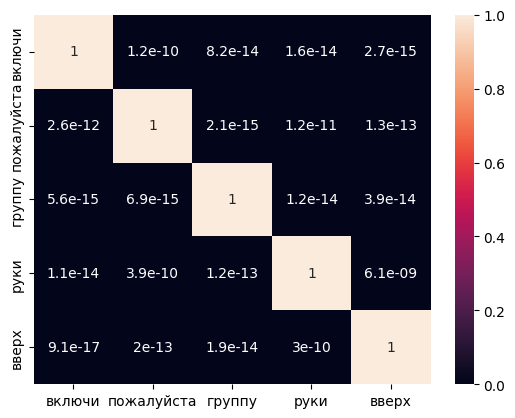

In [209]:
import seaborn as sns
sns.heatmap(scores_normalized, xticklabels=text.split(), yticklabels=text.split(), annot=True)

In [5]:
scores_normalized[:, 0].view(-1, 1)

tensor([[1.0000e+00],
        [2.6020e-12],
        [5.6052e-15],
        [1.0743e-14],
        [9.0800e-17]])

In [6]:
first_emb = (embeddings * scores_normalized[:, 0].view(-1, 1)).sum(dim=0)
first_emb

tensor([ 8.3382e-01, -2.1397e-01,  2.0033e-01, -2.3234e-02, -1.6352e-01,
        -3.1473e-01, -2.7189e-01,  1.7513e-01,  4.2780e-01,  3.4569e-01,
        -1.8912e-01, -2.5101e-02,  4.4553e-02, -6.3359e-01, -3.4898e-01,
         1.6900e-02, -2.2920e-02, -1.6965e-01,  1.5217e-01, -2.2922e-01,
        -8.7308e-01,  3.4396e-01, -6.2545e-03,  1.3233e-01, -4.0724e-01,
         3.1201e-01,  1.0364e-01, -2.7280e-01, -7.5732e-02,  2.6447e-01,
         1.0375e-01, -1.3977e-01, -5.4358e-01, -1.0175e-01,  2.3113e-02,
        -1.7922e-01, -1.4222e-01,  2.4688e-01,  7.0777e-01, -1.8071e-01,
        -9.9012e-02,  7.4856e-01,  3.4141e-01, -1.3784e-01,  2.0613e-02,
         2.7204e-01, -2.9992e-02,  2.3393e-01,  2.8204e-01,  1.0993e-01,
        -7.0768e-01, -2.0828e-03,  6.4351e-01, -8.2678e-02, -5.6086e-02,
        -4.7781e-03,  7.6802e-03,  2.0830e-01,  2.6347e-01,  4.4920e-02,
        -2.3996e-01, -2.0465e-01, -2.7938e-03,  1.9067e-01, -2.5622e-01,
        -8.0669e-02, -4.3525e-01, -3.1192e-01, -1.4

In [7]:
first_emb == embeddings[0]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [8]:
embeddings.shape

torch.Size([5, 300])

In [9]:
scores_normalized.shape

torch.Size([5, 5])

In [10]:
repeated_embeddings = embeddings.repeat(embeddings.shape[0], 1, 1)
repeated_embeddings.shape

torch.Size([5, 5, 300])

In [11]:
repeated_embeddings[:, 0, :]

tensor([[ 0.8338, -0.2140,  0.2003,  ...,  0.5876, -0.3866, -0.1288],
        [ 0.8338, -0.2140,  0.2003,  ...,  0.5876, -0.3866, -0.1288],
        [ 0.8338, -0.2140,  0.2003,  ...,  0.5876, -0.3866, -0.1288],
        [ 0.8338, -0.2140,  0.2003,  ...,  0.5876, -0.3866, -0.1288],
        [ 0.8338, -0.2140,  0.2003,  ...,  0.5876, -0.3866, -0.1288]])

In [12]:
permuted_embeddings = repeated_embeddings.permute(2, 0, 1)
permuted_embeddings.shape

torch.Size([300, 5, 5])

In [13]:
embeddings_attented = (permuted_embeddings * scores_normalized).sum(dim=2).permute(1, 0)
embeddings_attented.shape

torch.Size([5, 300])

In [14]:
embeddings_attented == embeddings

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

И тут пришло осознание...

In [44]:
(scores_normalized @ embeddings) == embeddings_attented

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [41]:
def lazy_self_attn(embeddings: torch.Tensor) -> torch.Tensor:
    """embeddings (seq_len, emb_dim)"""
    scores = embeddings @ embeddings.T  # (seq_len, seq_len)
    scores_normalized = scores.softmax(dim=1)  # (seq_len, seq_len)
    
    # repeated_embeddings = embeddings.repeat(embeddings.shape[0], 1, 1)  # (seq_len, seq_len, emb_dim)
    # permuted_embeddings = repeated_embeddings.permute(2, 0, 1)  # (emb_dim, seq_len, seq_len)

    # embeddings_attented = (permuted_embeddings * scores_normalized).sum(dim=2).permute(1, 0)  # (seq_len, emb_dim)

    embeddings_attented = scores_normalized @ embeddings

    return embeddings_attented

In [42]:
lazy_self_attn(embeddings).shape

torch.Size([5, 300])

<img src="attachements/second/self_attn_full.png" width="500"/>

**Весёлое упражнение:** батчизовать! Принимать на вход и возвращать `(B, seq_len, emb_dim)`. Без циклов, конечно.

Проблема: сильно слабый, не годится для хорошего понимания контекста.

### Перевод

<img src="attachements/second/attention_sentence.png" width="700"/>

### Scaled dot-product Attention

У нас есть две последовательности; одной нужно "смотреть" на другую.

- Query - что хотим найти? (токен, для которого хотим посчитать аттеншн)
- Key - что во мне содержится? (токены, на которые будем смотреть)
- Value - какая информация тебе нужна? (значения, которые будем получать)

<img src="attachements/second/attn_intuition.png" width="1400"/>

Query, Key, Value - обучаемые матрицы (по сути, обычные линейные слои).

<img src="attachements/second/attn_matrix_base.png" width="600"/>

Итоговая формула:

<img src="attachements/second/attention_matrices.webp" width="800"/>

<img src="attachements/second/attn_formula.png" width="800"/>

### Зачем скейлинг?

In [94]:
A = np.random.randn(10, 300)
B = np.random.randn(10, 300)

In [95]:
(A.std(), B.std())

(0.9977561371986308, 1.0241998510257033)

In [96]:
mul = (A @ B.T)
(mul).std()

17.742289134006796

In [97]:
mul_norm = mul / np.sqrt(A.shape[1])
(mul_norm).std()

1.0243515407558994

In [98]:
torch.from_numpy(mul).softmax(dim=0)[0]

tensor([9.9937e-01, 3.6610e-14, 9.5446e-16, 9.9918e-01, 1.3602e-08, 5.2080e-08,
        2.4273e-19, 7.4048e-06, 1.6817e-14, 3.7203e-02], dtype=torch.float64)

In [99]:
torch.from_numpy(mul_norm).softmax(dim=0)[0]

tensor([0.4006, 0.0634, 0.0476, 0.3284, 0.1333, 0.0753, 0.0318, 0.2393, 0.0343,
        0.2130], dtype=torch.float64)

### Пишем!

In [17]:
text2 = "руки вверх восемнадцать мне уже"

embeddings2 = list(map(navec.get, text2.split()))
embeddings2 = torch.from_numpy(np.stack(embeddings2))
embeddings2.shape

torch.Size([5, 300])

In [101]:
embeddings @ embeddings2.T

tensor([[ 0.7420, -1.0193,  0.5002,  1.5011, -0.6839],
        [11.2488,  6.6931,  5.1217, 15.4657,  6.2644],
        [ 3.1319,  4.3334,  4.2619,  3.9792,  4.6229],
        [32.9065, 13.9943,  1.9484, 10.9348,  8.9146],
        [13.9943, 35.9186,  3.1689,  4.2400,  5.2509]])

In [204]:
from torch import nn

class ScaledDotProductAttention(nn.Module):
    def __init__(self, emb_size):
        super().__init__()

        self.emb_size = emb_size
        self.scale = torch.sqrt(torch.tensor(emb_size))

        self.q_w = nn.Linear(emb_size, emb_size)
        self.k_w = nn.Linear(emb_size, emb_size)
        self.v_w = nn.Linear(emb_size, emb_size)

    def forward(self, x, y):
        xq = self.q_w(x)
        yk = self.k_w(y)
        yv = self.v_w(y)

        attn_scores = torch.softmax((xq @ yk.T) / self.scale, dim=-1)
        attn = attn_scores @ yv

        return attn, attn_scores


In [205]:
attn = ScaledDotProductAttention(300)

In [206]:
attn_, attn_scores = attn(embeddings, embeddings2)

In [207]:
attn_.shape

torch.Size([5, 300])

<Axes: >

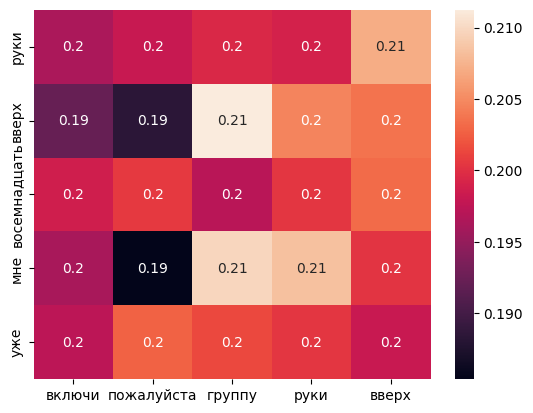

In [208]:
sns.heatmap(attn_scores.detach(), xticklabels=text.split(), yticklabels=text2.split(), annot=True)

### Генерация текста

<img src="attachements/second/gpt-2-output.gif" width="1200"/>

Важно генерировать, учитывая предыдущий контекст. Вспомните русский язык!

### Masked scaled dot-product Self-Attention

Одна последовательность - "смотрит" сама на себя.

<img src="attachements/second/attn_formula.png" width="800"/>

Формула не меняется. Только вместо двух различных последовательностей подается одна. \
Но есть один **нюанс**.

Хотим использовать выборку по максимуму.

In [135]:
from itertools import accumulate
list(accumulate(text.split(), lambda x, y: " ".join([x, y])))

['включи',
 'включи пожалуйста',
 'включи пожалуйста группу',
 'включи пожалуйста группу руки',
 'включи пожалуйста группу руки вверх']

Хотим делать **одно** вычисление, но при этом **не заглядывать в будущее**.

In [137]:
embeddings @ embeddings.T

tensor([[32.5143,  9.6992,  2.3823,  0.7420, -1.0193],
        [ 9.6992, 36.3740,  2.5938, 11.2488,  6.6931],
        [ 2.3823,  2.5938, 35.1974,  3.1319,  4.3334],
        [ 0.7420, 11.2488,  3.1319, 32.9065, 13.9943],
        [-1.0193,  6.6931,  4.3334, 13.9943, 35.9186]])

На выход приходит **маска**.

<img src="attachements/second/self_attn_mask.png" width="1200"/>

In [180]:
mask = torch.ones(embeddings.size(0), embeddings.size(0), dtype=torch.bool).triu(diagonal=1)
mask

tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])

In [177]:
scores_masked = scores.masked_fill(mask, -1e9)
scores_masked

tensor([[ 3.2514e+01, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 9.6992e+00,  3.6374e+01, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 2.3823e+00,  2.5938e+00,  3.5197e+01, -1.0000e+09, -1.0000e+09],
        [ 7.4198e-01,  1.1249e+01,  3.1319e+00,  3.2907e+01, -1.0000e+09],
        [-1.0193e+00,  6.6931e+00,  4.3334e+00,  1.3994e+01,  3.5919e+01]])

In [178]:
scores_masked.softmax(dim=1)

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.6020e-12, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [5.6052e-15, 6.9255e-15, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0743e-14, 3.9280e-10, 1.1723e-13, 1.0000e+00, 0.0000e+00],
        [9.0800e-17, 2.0302e-13, 1.9175e-14, 3.0088e-10, 1.0000e+00]])

### Заимплиментим!

In [199]:
class ScaledDotProductSelfAttention(nn.Module):
    def __init__(self, emb_size):
        super().__init__()

        self.emb_size = emb_size
        self.scale = torch.sqrt(torch.tensor(emb_size))

        self.q_w = nn.Linear(emb_size, emb_size)
        self.k_w = nn.Linear(emb_size, emb_size)
        self.v_w = nn.Linear(emb_size, emb_size)

    @staticmethod
    def _apply_mask(scores):
        size = scores.size(0)
        mask = torch.ones(size, size, dtype=torch.bool).triu(diagonal=1)

        return scores.masked_fill(mask, -1e9)

    def forward(self, x, y):
        xq = self.q_w(x)
        yk = self.k_w(y)
        yv = self.v_w(y)

        attn_scores = (xq @ yk.T)
        scores_masked = self._apply_mask(attn_scores)

        attn_scores = torch.softmax(scores_masked / self.scale, dim=-1)
        attn = attn_scores @ yv

        return attn, attn_scores


In [200]:
attn = ScaledDotProductSelfAttention(300)

In [201]:
attn_, attn_scores = attn(embeddings, embeddings)

In [202]:
attn_.shape

torch.Size([5, 300])

<Axes: >

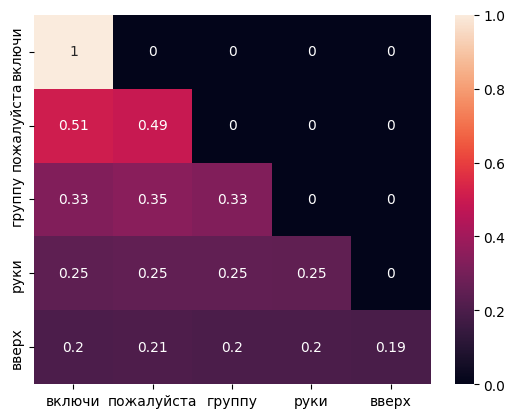

In [203]:
sns.heatmap(attn_scores.detach(), xticklabels=text.split(), yticklabels=text.split(), annot=True)

**Снова задачка:** батчизовать оба варианта!

### Multi-head Attention

Поводов посмотреть может быть много: coreference resolution, числа, роды, падежи...

Решение простое: сделаем несколько аттеншнов!

<img src="attachements/second/multihead_att_png.jpg" width="800"/>

<img src="attachements/second/multihead_attn.png" width="400"/>

### Почему мы надеемся получить различные ответы от разных голов? Последовательности-то одни.

1. Различная инициализация весов
2. Дропауты

### Реализация

Не очень отличается от предыдущей, нужно только добавить соответствующие проекции нескольких голов. \
Подробнее: https://nn.labml.ai/transformers/mha.html

## Transformer

Архитектура нейронных сетей, предложенная для решения задачи перевода. Состоит из:
- Энкодера - модуля, необходимого для "понимания" смысла исходной последовательности
- Декодера - модуля, необходимого для генерации выходного текста

<img src="attachements/second/transformer_architecture.webp" width="500"/>

### Токенизация

Проблема: много out-of-vocabulary слов. Особенно большая проблема при переводе. Коронавирус?

<img src="attachements/second/tokenization_explained.jpg" width="800"/>

#### Byte Pair Encoding

Byte Pair Encoding - это алгоритм сжатия данных, который итеративно объединяет самые частые пары последовательных байтов или символов в тексте, создавая новые подслова.

##### Training

Итеративно:
- Считаем все пары символов в тексте
- Находим самую частотную пару
- Объединяем эту пару (заодно сохраняем мердж в табличку мерджей - чтобы потом использовать)


Заканчиваем, когда набрали предопределенный размер словаря.

##### Inference

Итеративно:
- выбираем самый "топовый" мёрдж из таблицы
- применяем

Заканчиваем, когда больше нечего мерджить.

<img src="attachements/second/bpe_inference.png" width="450"/>

### Эмбеддинги

#### Эмбеддинги токенов

Такие же, как и раньше, только теперь сопоставляем вектора подсловам. Учим их вместе со всем трансформером.

<img src="attachements/first/vectors.png" width="800"/>


#### Позиционные эмбеддинги

Аттеншн не зависит от позиции, помните? Но в реальности порядок слов в тексте очень важен.

<img src="attachements/second/attn_order.avif" width="600"/>

Добавляем эмбеддинги позиций к основным эмбеддингам.

<img src="attachements/second/positional_encoding-min.png" width="600"/>

Можно сделать это многими способами, авторы делают это синусоидами:

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msub>
    <mstyle displaystyle="false" scriptlevel="0">
      <mtext>PE</mtext>
    </mstyle>
    <mrow data-mjx-texclass="ORD">
      <mi>p</mi>
      <mi>o</mi>
      <mi>s</mi>
      <mo>,</mo>
      <mn>2</mn>
      <mi>i</mi>
    </mrow>
  </msub>
  <mo>=</mo>
  <mi>sin</mi>
  <mo data-mjx-texclass="NONE">&#x2061;</mo>
  <mo stretchy="false">(</mo>
  <mi>p</mi>
  <mi>o</mi>
  <mi>s</mi>
  <mrow data-mjx-texclass="ORD">
    <mo>/</mo>
  </mrow>
  <msup>
    <mn>10000</mn>
    <mrow data-mjx-texclass="ORD">
      <mn>2</mn>
      <mi>i</mi>
      <mrow data-mjx-texclass="ORD">
        <mo>/</mo>
      </mrow>
      <msub>
        <mi>d</mi>
        <mrow data-mjx-texclass="ORD">
          <mi>m</mi>
          <mi>o</mi>
          <mi>d</mi>
          <mi>e</mi>
          <mi>l</mi>
        </mrow>
      </msub>
    </mrow>
  </msup>
  <mo stretchy="false">)</mo>
  <mo>,</mo>
</math>
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msub>
    <mstyle displaystyle="false" scriptlevel="0">
      <mtext>PE</mtext>
    </mstyle>
    <mrow data-mjx-texclass="ORD">
      <mi>p</mi>
      <mi>o</mi>
      <mi>s</mi>
      <mo>,</mo>
      <mn>2</mn>
      <mi>i</mi>
      <mo>+</mo>
      <mn>1</mn>
    </mrow>
  </msub>
  <mo>=</mo>
  <mi>cos</mi>
  <mo data-mjx-texclass="NONE">&#x2061;</mo>
  <mo stretchy="false">(</mo>
  <mi>p</mi>
  <mi>o</mi>
  <mi>s</mi>
  <mrow data-mjx-texclass="ORD">
    <mo>/</mo>
  </mrow>
  <msup>
    <mn>10000</mn>
    <mrow data-mjx-texclass="ORD">
      <mn>2</mn>
      <mi>i</mi>
      <mrow data-mjx-texclass="ORD">
        <mo>/</mo>
      </mrow>
      <msub>
        <mi>d</mi>
        <mrow data-mjx-texclass="ORD">
          <mi>m</mi>
          <mi>o</mi>
          <mi>d</mi>
          <mi>e</mi>
          <mi>l</mi>
        </mrow>
      </msub>
    </mrow>
  </msup>
  <mo stretchy="false">)</mo>
  <mo>,</mo>
</math>

### На самом деле...

<img src="attachements/second/transformer_layers.png" width="800"/>

### Энкодер

Принимает на вход токены. \
Возвращает: эмбеддинги токенов.

<img src="attachements/second/encoder.png" width="800"/>

#### Архитектура

Простая архитектура:
- Содержит N одинаковых блоков, которые идут друг за другом
- Multi-Head Self-Attention
- Add – resudial connection – просто добавляем к полученному результату Attention исходную матрицу
- Norm – LayerNorm – похоже на BatchNorm, но делается нормировка по другой оси – оси объекта
- Feed Forward – небольшая сеть из двух линейных слоев с нелинейностью
- Add & Norm точно такие же как и после Attention

<img src="attachements/second/encoder_arch.png" width="400"/>

### Почему LayerNorm лучше при обработке текстов?

<img src="attachements/second/normalizations.png" width="800"/>

#### Ответ

BatchNorm не очень эффективен для последовательностей с изменчивыми:
- длиной (не понятно, как считать константы нормализации)
- батч-сайзом (часто может быть маленьким)

### Декодер

Принимает на вход: эмбеддинги последовательности и эмбеддинги энкодера. \
Возвращает: вероятностьи следующего токена.

Работает итеративно, пока не сгенерит всю последовательность.

<img src="attachements/second/text_generation.png" width="800"/>

#### Архитектура

Снова простая, но чуть интереснее:
- Содержит N одинаковых блоков, которые идут друг за другом
- Masked Multi-Head Self-Attention
- Add & Norm
- Multi-Head Attention, где в качестве Key и Value – эмбединги с последнего слоя Encoder, а Query из текущего состояния Decoder
- Add & Norm
- Feed Forward
- Add & Norm

<img src="attachements/second/decoder.png" width="300"/>

### Итог

<img src="attachements/second/transformer_explained.png" width="1000"/>

## Хитрые вопросики

### Преимущества над RNN?

1. Лучше улавливает локальный и глобальный контексты, не забывает
2. Умеет параллелиться

### В чем проблемы относительно RNN?

1. Квардатичная зависимость от длины последовательности (для понимания и генерации, по памяти и вычислениям)

## Bye

<img src="attachements/second/thanks_attention.png" width="1200"/>